In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import optuna
from pathlib import Path
import os

DATA_DIR = Path('../data/processed')

Funciones adicionales:
Estimar RAM

In [82]:
CONFIGS = {
    "limited": {
        "function_5_sample": 500,
        "max_train": 10_000,
        "max_val": 2_000,
        "max_test": 1_000,
        "batch_size": 16
    },
    "basic": {
        "function_5_sample": 2_000,
        "max_train": 25_000,
        "max_val": 5_000,
        "max_test": 2_500,
        "batch_size": 32
    },
    "moderate": {
        "function_5_sample": 5_000,
        "max_train": 75_000,
        "max_val": 15_000,
        "max_test": 7_500,
        "batch_size": 64
    },
    "high": {
        "function_5_sample": 10_000,
        "max_train": 300_000,
        "max_val": 60_000,
        "max_test": 30_000,
        "batch_size": 128,
        "use_augmentation": True
    },
    "server": {
        "function_5_sample": 25_000,
        "max_train": 800_000,
        "max_val": 150_000,
        "max_test": 75_000,
        "batch_size": 256
    },
    # 🚀 NUEVA CONFIGURACIÓN PARA DATOS GRANDES
    "large_dataset": {
        "function_5_sample": 15_000,
        "max_train": 1_000_000,  # 1 millón de muestras
        "max_val": 200_000,      # 200K validación
        "max_test": 100_000,     # 100K test
        "batch_size": 128,
        "use_augmentation": True
    }
}

In [ ]:
CONFIG_NAME = "server"  # Cambia esto por: "limited", "basic", "moderate", "high", "server", o "large_dataset"
config = CONFIGS[CONFIG_NAME]

print(f"🎯 Usando configuración: {CONFIG_NAME.upper()}")
for key, value in config.items():
    if isinstance(value, int):
        print(f"  {key}: {value:,}")
    else:
        print(f"  {key}: {value}")

# Asignar valores para usar en el resto del código
optimal_sizes = config

🎯 Usando configuración: HIGH
  function_5_sample: 10,000
  max_train: 300,000
  max_val: 60,000
  max_test: 30,000
  batch_size: 128
  use_augmentation: 1


In [84]:
chess_train_df = pd.read_parquet(DATA_DIR / 'training_data.parquet')
chess_validation_df = pd.read_parquet(DATA_DIR / 'validation_data.parquet')
chess_test_df = pd.read_parquet(DATA_DIR / 'testing_data.parquet')

print(f"Datos de entrenamiento: {len(chess_train_df):,} posiciones")
print(f"Datos de validación: {len(chess_validation_df):,} posiciones")
print(f"Datos de prueba: {len(chess_test_df):,} posiciones")

Datos de entrenamiento: 11,610,568 posiciones
Datos de validación: 3,317,307 posiciones
Datos de prueba: 1,658,652 posiciones


In [85]:
def create_piece_mapping():
    """
    Crea un mapeo de piezas de ajedrez a índices numéricos.
    
    Returns:
        dict: Mapeo de símbolo de pieza -> índice (0-5)
              P=0, N=1, B=2, R=3, Q=4, K=5
    """
    piece_symbols = ["P", "N", "B", "R", "Q", "K"]  # Peón, Caballo, Alfil, Torre, Dama, Rey
    piece_to_index = {piece: idx for idx, piece in enumerate(piece_symbols)}
    return piece_to_index

piece_mapping = create_piece_mapping()
print("Mapeo de piezas:", piece_mapping)

Mapeo de piezas: {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5}


In [86]:
# === FUNCIÓN 2: Parser de fila del tablero ===
def parse_board_row(row_string, piece_mapping):
    """
    Convierte una fila FEN en representación one-hot de 8x12.
    
    Args:
        row_string (str): Fila del FEN (ej: "rnbqkbnr" o "pppppppp" o "8")
        piece_mapping (dict): Mapeo pieza -> índice
        
    Returns:
        list: Lista de 8 casillas, cada una con vector de 12 elementos
              [6 piezas blancas + 6 piezas negras] en one-hot
              
    Explicación del encoding:
    - Cada casilla = vector de 12 elementos [P,N,B,R,Q,K,p,n,b,r,q,k]
    - Mayúscula = pieza blanca (índices 0-5)
    - Minúscula = pieza negra (índices 6-11)
    - Número = casillas vacías consecutivas
    """
    row_squares = []
    
    for char in row_string:
        # Vector de 12 ceros para cada casilla (6 blancas + 6 negras)
        square_vector = [0] * (len(piece_mapping) * 2)
        
        if char in piece_mapping:  # Pieza blanca (mayúscula)
            square_vector[piece_mapping[char]] = 1
        elif char.upper() in piece_mapping:  # Pieza negra (minúscula)
            square_vector[piece_mapping[char.upper()] + len(piece_mapping)] = 1
        
        # Manejo de números (casillas vacías)
        num_empty_squares = int(char) if char.isdigit() else 1
        
        for _ in range(num_empty_squares):
            row_squares.append(square_vector.copy())
    
    return row_squares

# Prueba de la función
test_row = parse_board_row("rnbqkbnr", piece_mapping)
print(f"Fila parseada tiene {len(test_row)} casillas")
print(f"Primera casilla (torre negra): {test_row[0]}")

Fila parseada tiene 8 casillas
Primera casilla (torre negra): [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [87]:
# === FUNCIÓN 3: Parser completo de FEN ===
def parse_fen_to_tensor(fen_string, piece_mapping):
    """
    Convierte una posición FEN completa en tensor 8x8x12.
    
    Args:
        fen_string (str): Posición FEN completa
        piece_mapping (dict): Mapeo pieza -> índice
        
    Returns:
        tuple: (board_tensor, is_black_turn)
               - board_tensor: np.array shape (8,8,12)
               - is_black_turn: bool, True si le toca a negras
               
    Explicación de la normalización por turno:
    - Si le toca a negras, se invierte el tablero (flip vertical + swap colors)
    - Esto hace que la CNN siempre vea desde perspectiva del jugador activo
    """
    fen_parts = fen_string.split(" ")
    board_position = fen_parts[0]  # Solo la posición, no el turno ni otros datos
    active_color = fen_parts[1] if len(fen_parts) > 1 else 'w'
    
    is_black_turn = (active_color == "b")
    
    # Si le toca a negras, invertir colores para normalizar perspectiva
    if is_black_turn:
        # Invertir colores: mayúscula<->minúscula y reversa del string
        board_position = "".join(reversed(board_position.swapcase()))
    
    # Parsear cada fila (separadas por "/")
    board_rows = [parse_board_row(row, piece_mapping) for row in board_position.split("/")]
    board_tensor = np.array(board_rows)
    
    return board_tensor, is_black_turn

# Prueba con posición inicial
initial_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board_tensor, is_black = parse_fen_to_tensor(initial_fen, piece_mapping)
print(f"Tensor del tablero: {board_tensor.shape}")
print(f"¿Le toca a negras? {is_black}")

Tensor del tablero: (8, 8, 12)
¿Le toca a negras? False


In [88]:
# === FUNCIÓN 4: Parser de evaluaciones ===
def parse_evaluation_to_class(evaluation_string):
    """
    Convierte evaluación de Stockfish a clases: [Ventaja Blanca, Empate, Ventaja Negra].
    
    Args:
        evaluation_string (str): Evaluación ("#3", "0.5", "-2.1", etc.)
        
    Returns:
        int: 0=VentajaBlanca (>+1.5), 1=Empate (±1.5), 2=VentajaNegra (<-1.5)
        
    Explicación de umbrales:
    - Mate (#): se convierte a ±15.0 (muy alto)
    - >+1.5: ventaja significativa para blancas (clase 0)
    - [-1.5, +1.5]: posición equilibrada (clase 1) 
    - <-1.5: ventaja significativa para negras (clase 2)
    """
    eval_str = evaluation_string.strip()
    
    # Manejo de mates (formato #N o M±N)
    if eval_str.startswith("#"):
        mate_value = eval_str[1:] + "000"  # "#3" -> "30000" 
        eval_numeric = float(mate_value)
    else:
        eval_numeric = float(eval_str)
    
    # Umbrales de clasificación (en pawns/centipawns)
    WHITE_ADVANTAGE_THRESHOLD = 150  # +1.5 pawns
    BLACK_ADVANTAGE_THRESHOLD = -150  # -1.5 pawns
    
    if eval_numeric > WHITE_ADVANTAGE_THRESHOLD:
        return 0  # Ventaja blanca
    elif eval_numeric < BLACK_ADVANTAGE_THRESHOLD:
        return 2  # Ventaja negra
    else:
        return 1  # Empate/equilibrado


In [89]:
# === FUNCIÓN 5: Preprocessor completo ===
def preprocess_chess_position(row_data, piece_mapping):
    """
    Procesa una fila completa: FEN -> tensor + evaluación -> one-hot.
    
    Args:
        row_data (pd.Series): Fila con columnas ['FEN', 'Evaluation']
        piece_mapping (dict): Mapeo de piezas
        
    Returns:
        tuple: (board_tensor, evaluation_onehot)
               - board_tensor: (8,8,12) posición del tablero
               - evaluation_onehot: (3,) vector one-hot de la clase
    """
    fen_string = row_data.iloc[0]  # Asumiendo que FEN está en primera columna
    eval_string = row_data.iloc[1]  # Evaluación en segunda columna
    
    # Procesar posición
    board_tensor, is_black_turn = parse_fen_to_tensor(fen_string, piece_mapping)
    
    # Procesar evaluación
    eval_class = parse_evaluation_to_class(eval_string)
    
    # Si le toca a negras, invertir la evaluación
    if is_black_turn:
        eval_class = 2 - eval_class  # 0->2, 1->1, 2->0
    
    # Convertir a one-hot
    evaluation_onehot = np.zeros(3)
    evaluation_onehot[eval_class] = 1
    
    return board_tensor, evaluation_onehot


In [90]:
# === FUNCIÓN 6: Creación de arrays de entrenamiento ===
def create_training_arrays(dataframe, piece_mapping, max_samples=None):
    """
    Convierte DataFrame completo en arrays X, y listos para CNN.
    
    Args:
        dataframe (pd.DataFrame): Datos con columnas FEN y Evaluation
        piece_mapping (dict): Mapeo de piezas
        max_samples (int, optional): Límite de muestras para evitar memoria
        
    Returns:
        tuple: (X_array, y_array)
               - X_array: (N, 8, 8, 12) tensores de posiciones
               - y_array: (N, 3) evaluaciones one-hot
    """
    if max_samples:
        dataframe = dataframe.head(max_samples)
    
    print(f"Procesando {len(dataframe):,} posiciones...")
    
    # Aplicar preprocessing directo (como Kaggle)
    processed_data = dataframe.apply(
        lambda row: preprocess_chess_position(row, piece_mapping), 
        axis=1
    )
    
    # Separar X e y
    positions = [item[0] for item in processed_data]
    evaluations = [item[1] for item in processed_data]
    
    X = np.stack(positions, axis=0)
    y = np.stack(evaluations, axis=0)
    
    print(f"✅ Arrays creados: X{X.shape}, y{y.shape}")
    return X, y

In [91]:
X_train, y_train = create_training_arrays(
    chess_train_df, piece_mapping, optimal_sizes["max_train"]
)
X_val, y_val = create_training_arrays(
    chess_validation_df, piece_mapping, optimal_sizes["max_val"]
)

#Verificar distribución de clases actualizada
class_counts = np.sum(y_train, axis=0)
class_percentages = class_counts / len(y_train) * 100
print(f"\n📊 NUEVA DISTRIBUCIÓN DE CLASES:")
print(f"Clase 0 (Ventaja Blanca): {class_counts[0]:,.0f} ({class_percentages[0]:.1f}%)")
print(f"Clase 1 (Empate): {class_counts[1]:,.0f} ({class_percentages[1]:.1f}%)")
print(f"Clase 2 (Ventaja Negra): {class_counts[2]:,.0f} ({class_percentages[2]:.1f}%)")

print(f"\n✅ Dataset grande activado exitosamente!")
print(f"Factor de aumento real: {X_train.shape[0] / optimal_sizes['max_train']:.1f}x")

Procesando 300,000 posiciones...
✅ Arrays creados: X(300000, 8, 8, 12), y(300000, 3)
Procesando 60,000 posiciones...
✅ Arrays creados: X(60000, 8, 8, 12), y(60000, 3)

📊 NUEVA DISTRIBUCIÓN DE CLASES:
Clase 0 (Ventaja Blanca): 89,195 (29.7%)
Clase 1 (Empate): 144,554 (48.2%)
Clase 2 (Ventaja Negra): 66,251 (22.1%)

✅ Dataset grande activado exitosamente!
Factor de aumento real: 1.0x


In [92]:
# === FUNCIÓN 7: Construcción del modelo CNN ===
def create_chess_cnn_model(input_shape=(8, 8, 12)):
    """
    Construye modelo CNN para evaluación de posiciones de ajedrez.
    
    Arquitectura:
    1. Conv2D(250, 5x5) + ReLU: Extrae patrones locales de piezas
    2. Conv2D(150, 5x5) + ReLU: Refina características espaciales  
    3. Flatten: Convierte a vector 1D
    4. Dense(32) + ReLU: Capa fully connected para combinación de features
    5. Dense(3) + Softmax: Clasificación final (3 clases)
    
    Args:
        input_shape (tuple): Forma de entrada (8,8,12)
        
    Returns:
        keras.Model: Modelo CNN compilado
    """
    chess_model = Sequential([
        # Arquitectura ganadora de Kaggle
        Conv2D(250, kernel_size=5, padding="same", 
               activation="relu", input_shape=input_shape),
        Conv2D(150, kernel_size=5, padding="same", activation="relu"),
        Flatten(),  # ← Mantener información espacial completa
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),
    ])
    
    # Configuración simple y efectiva
    chess_model.compile(
        optimizer="adam",  # ← Adam default funciona mejor
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )
    
    return chess_model

# Crear y mostrar modelo
chess_cnn_model = create_chess_cnn_model()
chess_cnn_model.summary()

c:\Users\ASUS\Desktop\stocksalmon\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 250)      │        75,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 150)      │       937,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │       307,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,231 (5.04 MB)

 Trainable params: 1,320,231 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
def get_improved_callbacks():
    """
    Callback para mejor entrenamiento y prevención de overfitting.
    """
    callback = [
        # Early stopping más estricto
        EarlyStopping(
            monitor='val_categorical_accuracy',
            patience=5,
            restore_best_weights=True,
        )
    ]
    return callback

In [94]:
# === FUNCIÓN 8: Entrenamiento del modelo ===

history = chess_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=get_improved_callbacks(),
    verbose=1
)

Epoch 1/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 199s 85ms/step - categorical_accuracy: 0.6051 - loss: 0.8458 - val_categorical_accuracy: 0.6392 - val_loss: 0.7931
Epoch 2/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 204s 87ms/step - categorical_accuracy: 0.6605 - loss: 0.7534 - val_categorical_accuracy: 0.6314 - val_loss: 0.8006
Epoch 3/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - categorical_accuracy: 0.6993 - loss: 0.6820 - val_categorical_accuracy: 0.6555 - val_loss: 0.7637
Epoch 4/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 204s 87ms/step - categorical_accuracy: 0.7431 - loss: 0.5988 - val_categorical_accuracy: 0.6533 - val_loss: 0.8108
Epoch 5/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 206s 88ms/step - categorical_accuracy: 0.7928 - loss: 0.4967 - val_categorical_accuracy: 0.6476 - val_loss: 0.9035
Epoch 6/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 208s 89ms/step - categorical_accuracy: 0.8401 - loss: 0.3922 - val_categorical_accuracy: 0.6373 - val_loss: 1.0078
Epoch 7/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 209s 89ms

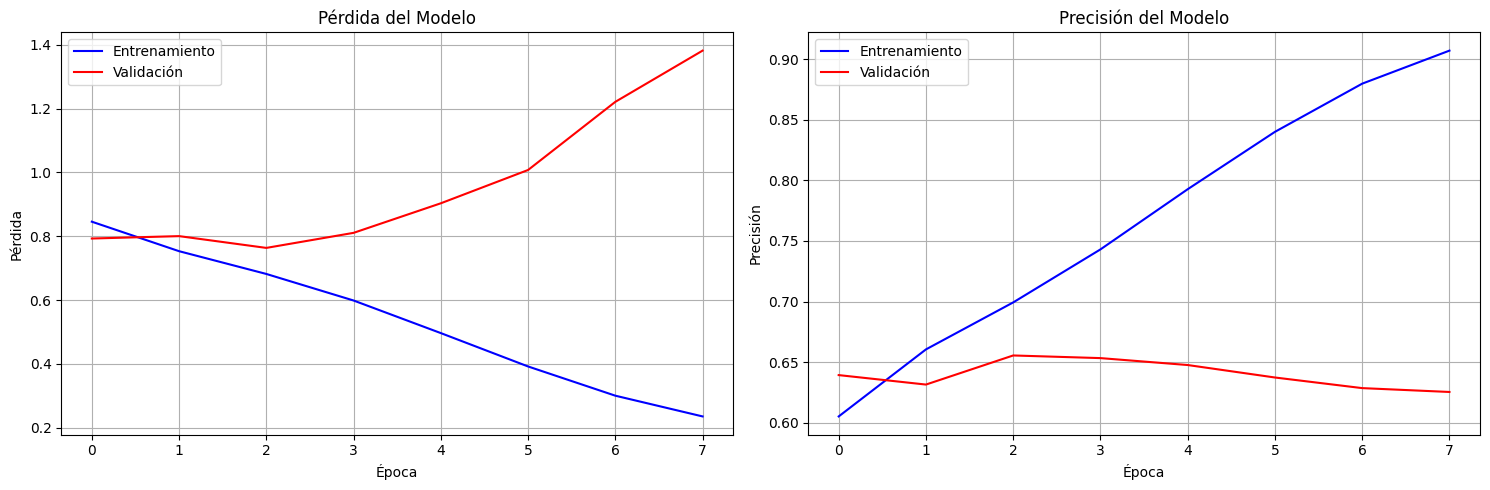

In [95]:
# === FUNCIÓN 9: Visualización de resultados ===

def plot_training_history(history):
    """
    Grafica métricas de entrenamiento vs validación.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento', color='blue')
    ax1.plot(history.history['val_loss'], label='Validación', color='red')
    ax1.set_title('Pérdida del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)
    
    # Precisión
    ax2.plot(history.history['categorical_accuracy'], label='Entrenamiento', color='blue')
    ax2.plot(history.history['val_categorical_accuracy'], label='Validación', color='red')
    ax2.set_title('Precisión del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar entrenamiento
plot_training_history(history)

In [96]:
# === Evaluación final en datos de prueba ===
if len(chess_test_df) > 0:
    print("Creando datos de prueba...")
    X_test, y_test = create_training_arrays(chess_test_df, piece_mapping, 5000)
    
    # Evaluar modelo
    test_results = chess_cnn_model.evaluate(X_test, y_test, verbose=1)
    print(f"\nResultados en datos de prueba:")
    print(f"Pérdida: {test_results[0]:.4f}")
    print(f"Precisión: {test_results[1]:.4f}")
    
    # Predicciones de ejemplo
    sample_predictions = chess_cnn_model.predict(X_test[:5])
    print(f"\nEjemplo de predicciones:")
    class_names = ['Ventaja Blanca', 'Empate', 'Ventaja Negra']
    for i, pred in enumerate(sample_predictions):
        predicted_class = np.argmax(pred)
        confidence = pred[predicted_class]
        print(f"Posición {i+1}: {class_names[predicted_class]} (confianza: {confidence:.3f})")

Creando datos de prueba...
Procesando 5,000 posiciones...
✅ Arrays creados: X(5000, 8, 8, 12), y(5000, 3)
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - categorical_accuracy: 0.6750 - loss: 0.7425

Resultados en datos de prueba:
Pérdida: 0.7425
Precisión: 0.6750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Ejemplo de predicciones:
Posición 1: Empate (confianza: 0.389)
Posición 2: Ventaja Negra (confianza: 0.493)
Posición 3: Empate (confianza: 0.593)
Posición 4: Ventaja Blanca (confianza: 0.899)
Posición 5: Ventaja Negra (confianza: 0.796)
